# Linear regression comparison of tools

In [6]:
import pandas as pd
from pathlib import Path # type: ignore
from freyja_plot import FreyjaPlotter
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
if (module_path:=str(Path(".").absolute().resolve().parent)) not in sys.path:
    sys.path.insert(0, module_path)
from sample_info import renameSamples, summary_dict, expected, artic_runs as runs

## Collect lineage/abundance info for all samples for all tools

In [7]:
file_map = {expected:"Expected"}
for tool, files in runs.items():
    for name,file in files.items():
        if "WB" == name:
            file_map[file] = tool
plotter = FreyjaPlotter(
    file_map=file_map,
    # colormap=colormap,
    summary_dict=summary_dict,
)
plotter = renameSamples(plotter)
df = plotter.summarized_freyja_df.rename(columns={"Sample name":"sample","abundances":"abundance","scheme":"tool","lineages":"lineage"})
df

,sample,lineage,abundance,tool
2433,0,BG.X,0.0005,LCS
3201,0,Mu,0.0021,LolliPop
2432,0,Theta,0.0005,LCS
3200,0,XBB.1.16* [Omicron (XBB.1.16.X)],0.0023,LolliPop
1502,0,Wuhan-hu-1,0.9110,kallisto (C-WAP)
...,...,...,...,...
1003,o5-3,BA.4.X,0.0248,kallisto
1747,o5-3,Alpha,0.0080,kallisto (C-WAP)
1746,o5-3,BA.1.X,0.0090,kallisto (C-WAP)
1009,o5-3,Beta,0.0053,kallisto


## Gather L2 median results in an array

In [8]:
lineages = set(df["lineage"].unique())
l2_tools = set(runs.keys())
l2s = []

# for each sample, calculate l2 array for the tools
for sample in set(df["sample"].unique()) - {None}:
    sample_df = df.loc[df['sample'] == sample, ('tool', 'lineage', 'abundance')]
    
    pivoted_sample_df = sample_df.pivot_table(index='lineage', columns='tool', values='abundance').fillna(0).T

    # for any missing tool, append 0-abundance df to bottom
    dfs2append = []
    missing_tools = l2_tools - set(pivoted_sample_df.index.unique())
    for tool in missing_tools:
        dfs2append.append(
            pd.DataFrame({lin:[0] for lin in lineages},index=[tool])
        )
    if dfs2append:
        pivoted_sample_df = pd.concat([pivoted_sample_df]+dfs2append).fillna(0)
    pivoted_sample_df = pivoted_sample_df.reindex(["Expected"] + [x for x in pivoted_sample_df.index if x != "Expected"])

    Y = squareform(pdist(pivoted_sample_df, 'euclidean'))
    l2s.append(Y)

# get order of tools, as they appear in the l2s
l2_index = pivoted_sample_df.index

# combine l2 results into a single condenced array
l2s_stacked = np.stack(l2s)
l2m = np.median(l2s_stacked, axis=0)
l2m

array([[0.        , 0.06696109, 0.01895415, 0.96033738, 0.22172948,
        0.34253773, 0.11745   , 0.34429852, 0.28343631, 1.14007147],
       [0.06696109, 0.        , 0.05136858, 0.92638328, 0.07556258,
        0.2586512 , 0.07516003, 0.31047524, 0.23643818, 1.09207959],
       [0.01895415, 0.05136858, 0.        , 0.84437698, 0.11133303,
        0.2871047 , 0.09512895, 0.31233022, 0.31378471, 1.12876971],
       [0.96033738, 0.92638328, 0.84437698, 0.        , 0.8586727 ,
        0.55175498, 0.73780186, 0.7021982 , 0.59680039, 1.07259802],
       [0.22172948, 0.07556258, 0.11133303, 0.8586727 , 0.        ,
        0.32238458, 0.14857574, 0.32829116, 0.31496198, 0.99953651],
       [0.34253773, 0.2586512 , 0.2871047 , 0.55175498, 0.32238458,
        0.        , 0.3290404 , 0.26175679, 0.21503004, 0.98078656],
       [0.11745   , 0.07516003, 0.09512895, 0.73780186, 0.14857574,
        0.3290404 , 0.        , 0.30103435, 0.30773341, 1.08444326],
       [0.34429852, 0.31047524, 0.3123302

## Reorder array: lowest to highest (best to worst)

In [9]:
expected_vs_tools = list(l2m[0])
if len(set(expected_vs_tools)) < len(expected_vs_tools):
    raise Exception("Can't sort things when any values are duplicated")
idx = [expected_vs_tools.index(x) for x in sorted(expected_vs_tools)]
l2m_clustered = l2m[idx,:]
l2m_clustered = l2m_clustered[:,idx]
l2m_clustered

array([[0.        , 0.01895415, 0.06696109, 0.11745   , 0.22172948,
        0.28343631, 0.34253773, 0.34429852, 0.96033738, 1.14007147],
       [0.01895415, 0.        , 0.05136858, 0.09512895, 0.11133303,
        0.31378471, 0.2871047 , 0.31233022, 0.84437698, 1.12876971],
       [0.06696109, 0.05136858, 0.        , 0.07516003, 0.07556258,
        0.23643818, 0.2586512 , 0.31047524, 0.92638328, 1.09207959],
       [0.11745   , 0.09512895, 0.07516003, 0.        , 0.14857574,
        0.30773341, 0.3290404 , 0.30103435, 0.73780186, 1.08444326],
       [0.22172948, 0.11133303, 0.07556258, 0.14857574, 0.        ,
        0.31496198, 0.32238458, 0.32829116, 0.8586727 , 0.99953651],
       [0.28343631, 0.31378471, 0.23643818, 0.30773341, 0.31496198,
        0.        , 0.21503004, 0.32982084, 0.59680039, 1.10328186],
       [0.34253773, 0.2871047 , 0.2586512 , 0.3290404 , 0.32238458,
        0.21503004, 0.        , 0.26175679, 0.55175498, 0.98078656],
       [0.34429852, 0.31233022, 0.3104752

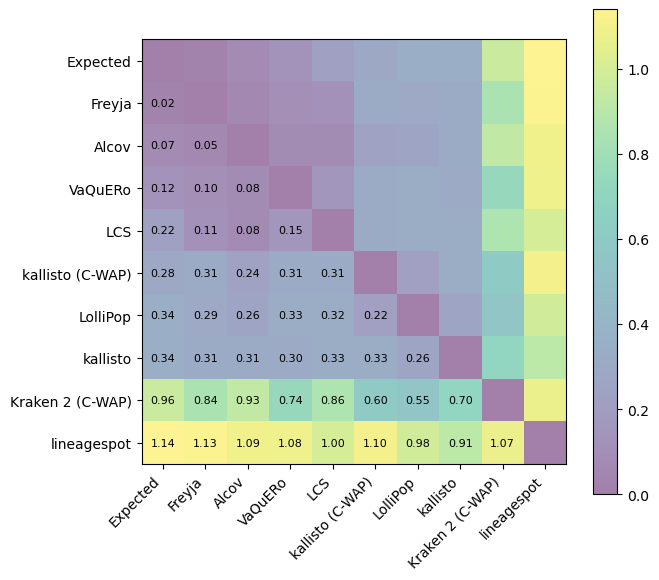

In [10]:
# plot
fig, (ax) = plt.subplots(1, 1, figsize=(6.85, 9))

N = len(l2_index)

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

for (j,i), label in np.ndenumerate(l2m_clustered):
    if j > i:
        ax.text(i, j,'{:.2f}'.format(label), ha='center', va='center', fontsize=8)

cmap = matplotlib.colormaps.get_cmap('viridis') # jet doesn't have white color
cmap.set_bad('w') # default value is 'k'

im = ax.imshow(l2m_clustered, alpha=0.5, cmap=cmap, aspect='equal')
fig.colorbar(im, ax=ax, shrink=0.7)

ax.set_xticks(np.arange(N))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(l2_index[idx], rotation=45, ha='right')
ax.set_yticklabels(l2_index[idx])

fig.savefig('L2_matrix_artic.tiff', bbox_inches='tight')
fig.savefig('L2_matrix_artic.png', bbox_inches='tight')